In [149]:
import dtoolcore
import dtoolcore.utils as utils
import time
import numpy as np
import json
import matplotlib.pyplot as plt
import os
import re
from dx_utils import zetta
import itertools
from itertools import permutations
import matplotlib as mpl

mpl.rcParams.update({
    "font.sans-serif": ["Arial"],
    "font.cursive": ["Arial"],
    "font.family": "serif",
    "font.serif": ["Arial"],
    "font.size": 14,
    "xtick.labelsize": 11,
    "ytick.labelsize": 11,
    "legend.fontsize": 14,
    "svg.fonttype": "none"
})

def ret_fig_ax(rows=1, cols=1):
    fig_width_pt = 448.13095  # Replace with your document's text width
    inches_per_pt = 1 / 72.27
    fig_width_in = fig_width_pt * inches_per_pt
    fig, ax = plt.subplots(rows,cols, figsize=( fig_width_in*2, fig_width_in )) #, sharey=True)
    #ax.set_aspect('equal')
    return fig, ax

In [77]:
rootdir = os.getcwd()

# pat = r'canal_\d+\.\d+_\d+'
pat = r'\d+\.\d+'
path = rootdir+"/dtool_db/"
#print(path)
def get_data_directories(root_dir):
    data_dirs = []
    for root, dirs, files in os.walk(root_dir):
        if root.endswith('/data'):
            data_dirs.append(root)
    return data_dirs

datadir_list = get_data_directories(path)

In [78]:
datadir_list

['/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_750.0_600.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_1000.0_600.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_650.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_650.0_612.5/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_750.0_587.5/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_850.0_612.5/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_650.0_562.5/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_850.0_600.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_750.0_550.0/data',
 '/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_cana

In [35]:
from dtoolcore import DataSet
import json

def get_height_from_dtool(dataset_uri):
    ## Dataset-level metadata
    dataset = DataSet.from_uri(dataset_uri)
    
    # Load the dataset
    dataset = DataSet.from_uri(dataset_uri)
    
    # Get the 'metadata' annotation
    metadata = dataset.get_annotation("metadata")
    
    # Print the metadata
    res = metadata[0]
    if res["p0"] ==0:
        return 1, np.ones(500)
    y = zetta(res["p0"], res["pl"], res["pg"],2,1000, num=500)
    
    return np.min(y), y

def find_matching_files(directory, pattern):
    regex = re.compile(pattern)
    matching_files = []
    for root, dirs, files in os.walk(directory):
        for file in files:
            if regex.search(os.path.join(root, file)):
                matching_files.append(os.path.join(root, file))
    return matching_files

def detect_segments(data, threshold):
    differences = np.abs(np.diff(data))
    discontinuities = np.where(differences > threshold)[0]
    segments = np.split(data, discontinuities + 1)
    return segments

def find_best_order(segments):
    n = len(segments)
    best_order = list(range(n))
    best_score = float('inf')
    
    for perm in itertools.permutations(range(n)):
        reordered = np.concatenate([segments[i] for i in perm])
        score = np.sum(np.abs(np.diff(reordered)))
        if score < best_score:
            best_score = score
            best_order = perm
    
    return best_order

def correct_profile(data, threshold):
    segments = detect_segments(data, threshold)
    best_order = find_best_order(segments)
    corrected = np.concatenate([segments[i] for i in best_order])
    return corrected


#print(get_height_from_dtool("/home/sick/Documents/GIT/bsc-ilia-fedotov/conda/mpi_run/dtool_db/iterative_canal_540.0_560.0"))

p0:  367.95040442245295  pg:  650  pl:  183.73900395886483
p0:  378.1684877255189  pg:  750  pl:  173.84641638705062
p0:  389.2055294628545  pg:  850  pl:  162.9399193132741
p0:  363.32359810598155  pg:  600  pl:  188.18283947483465
p0:  383.5493401813887  pg:  800  pl:  168.50529734604032
p0:  395.0372249744265  pg:  900  pl:  157.1607235644984
p0:  401.5886016532709  pg:  950  pl:  151.26389235456472
p0:  330.0077928448634  pg:  1000  pl:  220.00901975799573
p0:  373.0447374594777  pg:  700  pl:  178.90585017124997


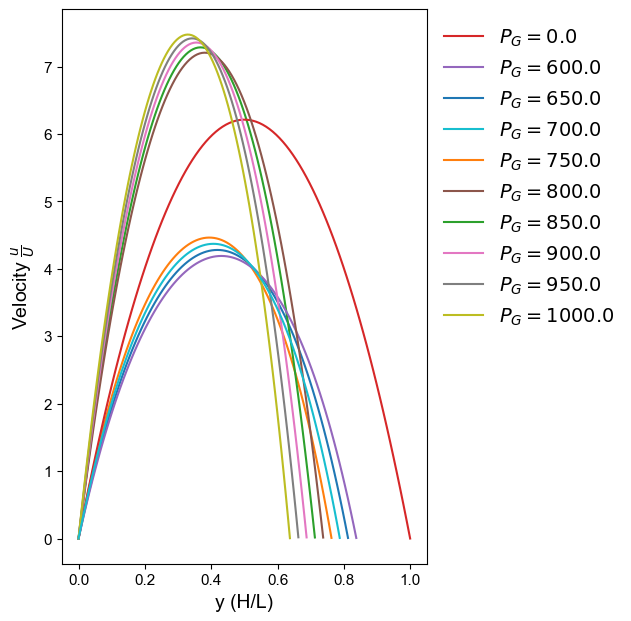

In [79]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

from label_lines import label_lines
#label_lines(plt.gca().get_lines(),xvals=(0.9,0.9,0.9),rotations=(0,0,0))

def plot_press(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = ret_fig_ax()
    #ax.set_title(title)
    pg = "550.0"    

    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue

        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        h_max, _ = get_height_from_dtool(re.sub(r'\/data$', r'', i))
        file_path = matching_files[0]
        u = np.loadtxt(file_path)
        #rolled_back = correct_profile(u[:,0], .4)
        ax.plot(np.linspace(0,h_max,100),u[:,0], label=rf"$P_G={extracted}$")

    handles, labels = plt.gca().get_legend_handles_labels()
    extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, 1), loc='upper left',frameon=False)
    plt.tight_layout()
    #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    ax.set_ylabel(r'Velocity $\frac{u}{U}$', fontsize=14)
    ax.set_xlabel(r'y (H/L)', fontsize=14)

    fig.savefig("fixed_velocity_pofiles.pdf", format='pdf', dpi=300, bbox_inches='tight')
    plt.show()


arr = plot_press(pat, pat2, "/v_at_5_.*_0.16/y_at_5_.*.txt", "Pressure Distribution", yl='P delta', legend=True)

[   0.  600.  650.  700.  750.  800.  850.  900.  950. 1000.] [550.  562.5 575.  587.5 600.  612.5 625.  637.5 650. ] (10, 9)


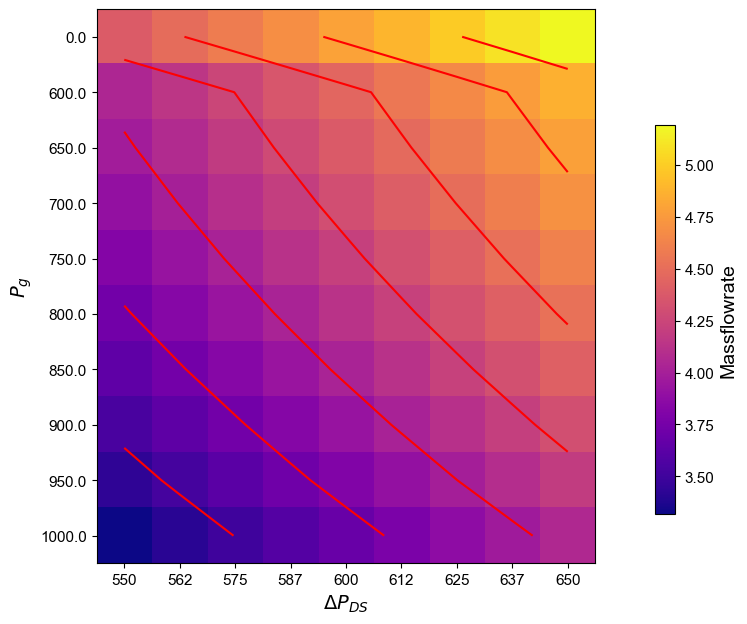

In [147]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

from label_lines import label_lines
#label_lines(plt.gca().get_lines(),xvals=(0.9,0.9,0.9),rotations=(0,0,0))

def plot_press(pt, pt2, file, title,legend=True, filename="output.pdf"):
    fig, ax = ret_fig_ax()
    #ax.set_title(title)
    pg = "740.0"    

    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    print(radii, press, arr.shape)

    
    for i in datadir_list:
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        u = np.loadtxt(i+file)
        arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = u[0]

    #handles, labels = plt.gca().get_legend_handles_labels()
    #extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    #sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    #sorted_handles, sorted_labels = zip(*sorted_pairs)
    #plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, 1), loc='upper left',frameon=False)
    
    neg = ax.imshow(arr, cmap="plasma")
    ax.contour(arr, colors='red')
    #ax.contour(arr, colors='red')
    ax.set_xticks(np.arange(len(press)))
    ax.set_yticks(np.arange(len(radii)))
    ax.set_xticklabels((press).astype(int))
    ax.set_yticklabels(radii)
    plt.tight_layout()
    #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7, label="Massflowrate")
    ax.set_ylabel(r'$P_g$', fontsize=14)
    ax.set_xlabel(r'$\Delta P_{DS}$', fontsize=14)

    plt.show()
    fig.savefig("massflow_membrane.pdf", format='pdf', dpi=300, bbox_inches='tight')
    return radii, press, arr


radii, press, arr = plot_press(pat, pat2, "/flux_trapz_0.32/flux_trapz.txt", "Massflowrate", legend=True)

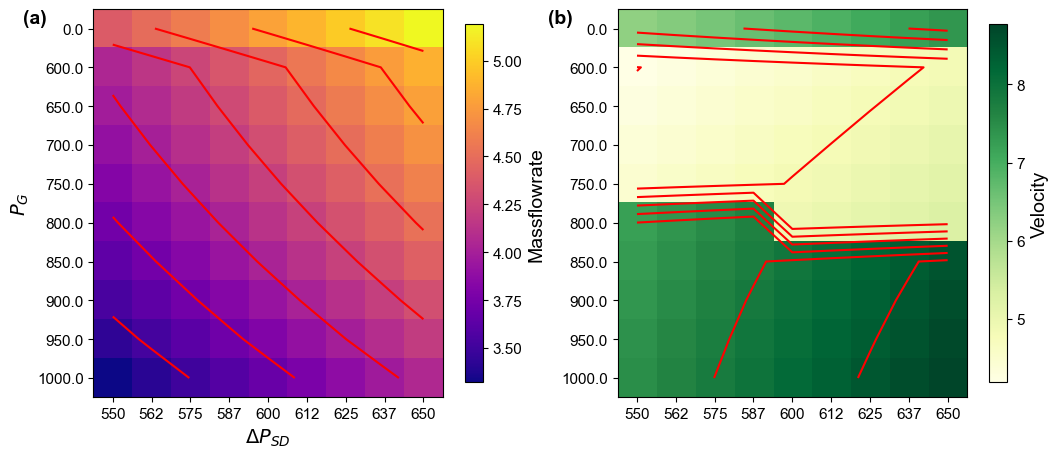

In [159]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

def plot_press_2(pt, pt2, file,ax, yl='Velocity', legend=True, filename="output.pdf", cmap='YlGn'):
    #fig, ax = ret_fig_ax()
    #ax.set_title(title)
    pg = "740.0"    

    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    # print(radii, press, arr.shape)

    
    for i in datadir_list:
        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        file_path = matching_files[0]
        if legend:
            u = np.loadtxt(i+file)
            arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = u[0]
        else:
            u = np.loadtxt(file_path)
            arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = np.max(u)            

    if legend:
        #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7)
        ax.set_ylabel(r'$P_G$')#, fontsize=14)
        ax.set_xlabel(r'$\Delta P_{SD}$')#, fontsize=14)
    neg = ax.imshow(arr,cmap=cmap)
    ax.contour(arr, colors='red')
    ax.set_xticks(np.arange(len(press)))
    ax.set_yticks(np.arange(len(radii)))
    ax.set_xticklabels((press).astype(int))
    ax.set_yticklabels(radii)

    #plt.show()
    #fig.savefig("velocities_membrane.pdf", format='pdf', dpi=300, bbox_inches='tight')
    return neg, radii, press, arr

fig, ax = ret_fig_ax(1,2)
neg, radii, press, arr = plot_press_2(pat, pat2, "/flux_trapz_0.32/flux_trapz.txt",ax[0], yl='P delta', legend=True, cmap="plasma")
neg1, radii1, press1, arr1 = plot_press_2(pat, pat2, "/y_at_5_.*_0.32/y_at_5_.*.txt",ax[1], yl='P delta', legend=False, cmap='YlGn')
#plt.tight_layout()
ax[0].text(-0.2, 1.0, '(a)', transform=ax[0].transAxes, fontsize=14, fontweight='bold', va='top')
ax[1].text(-0.2, 1.0, '(b)', transform=ax[1].transAxes, fontsize=14, fontweight='bold', va='top')
fig.colorbar(neg1, ax=ax[1], location='right', anchor=(0, 0.5), shrink=0.75, label="Velocity")
fig.colorbar(neg, ax=ax[0], location='right', anchor=(0, 0.5), shrink=0.75, label="Massflowrate")
fig.savefig("velocities_massflow_membrane.pdf", format='pdf', dpi=300, bbox_inches='tight')

In [ ]:
a,b,c,d = 5.82, 5.98, 6.1,6.23


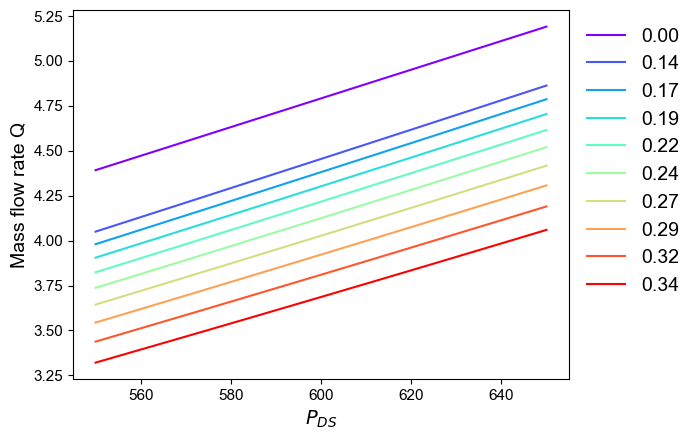

In [113]:
max_h = [0.78,0.71,0.66,0.76,0.68,1,0.73,0.86,0.83,0.81]
max_h = np.abs(np.sort(max_h)[::-1]-1)

max_h_formatted = [f'{x:.2f}' for x in max_h]
lines = plt.plot(press, arr.T, label=max_h_formatted)
plt.ylabel("Mass flow rate Q")
#plt.gca().set_yticks(np.arange(len(radii)))
#plt.gca().set_yticklabels((radii).astype(int))
plt.xlabel(r'$P_{DS}$')
colors = plt.cm.rainbow(np.linspace(0, 1, max_h.size))
for line, color in zip(lines, colors):
    line.set_color(color)

plt.legend(frameon=False,bbox_to_anchor=(1.0, 1), loc='upper left')
fig = plt.gcf()
fig.savefig("mass_flow_lin_55-65.pdf", format='pdf', dpi=300, bbox_inches='tight')

In [106]:
arr.T[:,0]

array([4.16173546, 4.25632046, 4.35090546, 4.44549047, 4.54007548,
       4.6346605 , 4.72924552, 4.82383054, 4.91841558])

[   0.  600.  650.  700.  750.  800.  850.  900.  950. 1000.] [650.] (10, 1)
p0:  441.13975167483284  pg:  750  pl:  211.47657256904705
0.7877238797800765
p0:  460.1372595973852  pg:  900  pl:  192.73069104578056
0.712785509463111
p0:  390.00931178327806  pg:  1000  pl:  260.0106791764026
0.6624194596634336
p0:  447.14889744734523  pg:  800  pl:  205.53399742121857
0.7627443205273989
p0:  467.84367684641904  pg:  950  pl:  186.07738921580437
0.6880391539391653
1
p0:  453.56445815774515  pg:  850  pl:  199.2116100323399
0.7377672564892841
p0:  424.00533849139475  pg:  600  pl:  227.61049608327866
0.8624190684994502
p0:  429.4895378399967  pg:  650  pl:  222.5253521262035
0.8375475257430149
p0:  435.4212661010503  pg:  700  pl:  217.26067946982732
0.8127308961951312


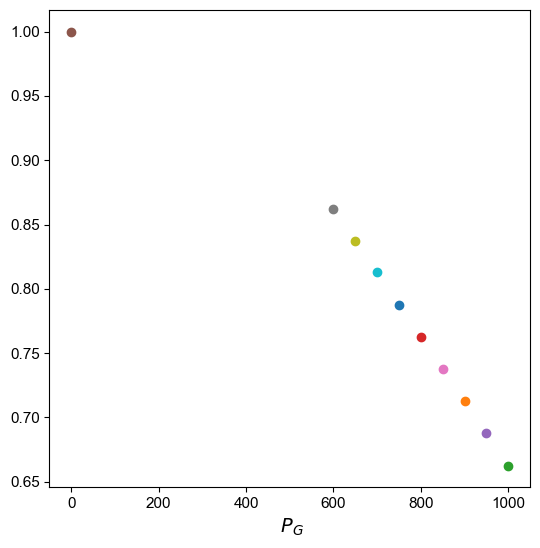

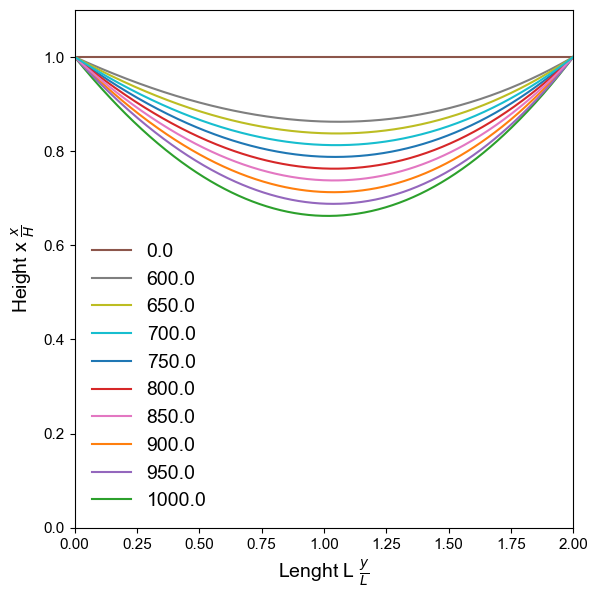

In [99]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

#label_lines(plt.gca().get_lines(),xvals=(0.9,0.9,0.9),rotations=(0,0,0))

def plot_ymax(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = ret_fig_ax()
    fig2, ax2 = ret_fig_ax()
    #ax.set_title(title)
    pg = "650.0"
    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    arr = np.empty((len(radii), len(press)))
    print(radii, press, arr.shape)

    
    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue

        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        h_max, y = get_height_from_dtool(re.sub(r'\/data$', r'', i))
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        # file_path = matching_files[0]
        # u = np.loadtxt(file_path)
        #arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = h_max
        ax.scatter(extracted,h_max)
        print(h_max)
        ax2.plot(np.linspace(0,2,500),y, label=extracted)

    handles, labels = plt.gca().get_legend_handles_labels()
    extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    ax2.legend(sorted_handles, sorted_labels, loc='lower left',frameon=False)
    
    #neg = ax[1].plot(arr)
    #ax.contour(arr, colors='red')
    #ax.set_xticks(np.arange(len(press)))
    #ax.set_yticks(np.arange(len(radii)))
    #ax.set_xticklabels((press).astype(int))
    #ax.set_yticklabels(radii)
    #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    #fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7, label="Velocity")
    ax2.set_ylabel(r'Height x $\frac{x}{H}$', fontsize=14)
    ax2.set_xlabel(r'Lenght L $\frac{y}{L}$', fontsize=14)
    ax2.set_ylim(0,1.1)
    ax2.set_xlim(0,2)
    
    #ax.set_aspect('equal', adjustable='box')
    #ax2.set_aspect('equal', adjustable='box')
    
    ax.set_xlabel(r' $P_G$', fontsize=14)
    #ax.set_ylabel(r'Height x $\frac{x}{H}$', fontsize=14)

    plt.tight_layout()
    fig.savefig("memb_courve.pdf", format='pdf', dpi=300, bbox_inches='tight')
    fig2.savefig("h_max_scatt.pdf", format='pdf', dpi=300, bbox_inches='tight')
    
    plt.show()
    return radii, press, arr


radii, press, arr = plot_ymax(pat, pat2, "/y_at_5_.*_0.16/y_at_5_.*.txt", r"Velocity at different $P_g$", yl='P delta', legend=True)

In [137]:
print(arr[2,:])

[0.86240897 0.86552844 0.86866441 0.87174965 0.87482472 0.11252047
 0.11794448 0.10003085 0.11670419]


p0:  367.95040442245295  pg:  650  pl:  183.73900395886483
p0:  378.1684877255189  pg:  750  pl:  173.84641638705062
p0:  389.2055294628545  pg:  850  pl:  162.9399193132741
p0:  363.32359810598155  pg:  600  pl:  188.18283947483465
p0:  383.5493401813887  pg:  800  pl:  168.50529734604032
p0:  395.0372249744265  pg:  900  pl:  157.1607235644984
p0:  401.5886016532709  pg:  950  pl:  151.26389235456472
p0:  330.0077928448634  pg:  1000  pl:  220.00901975799573
p0:  373.0447374594777  pg:  700  pl:  178.90585017124997


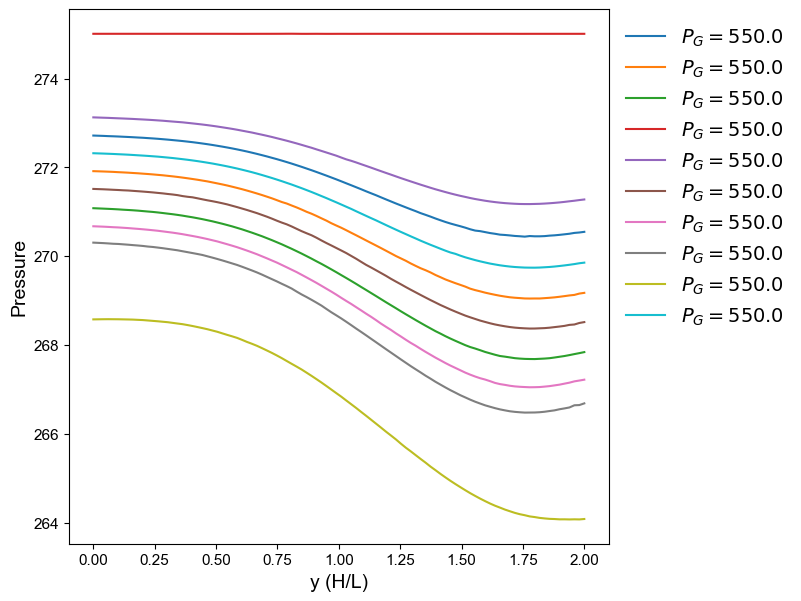

In [92]:
pat = r'\d+\.\d+(?=_)'
pat2 = r'\d+\.\d+(?=/)'

from label_lines import label_lines
#label_lines(plt.gca().get_lines(),xvals=(0.9,0.9,0.9),rotations=(0,0,0))

def plot_prs(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = plt.subplots(figsize=(8,6))
    #ax.set_title(title)
    pg = "550.0"    

    for i in datadir_list:
        if not re.search(r'' + re.escape(pg) + r'\/data$', i):
            continue

        #directory = os.path.dirname(i)
        #file_pattern = os.path.basename(file)
        #matching_files = find_matching_files(directory, file_pattern)
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        h_max, _ = get_height_from_dtool(re.sub(r'\/data$', r'', i))
        #file_path = matching_files[0]
        u = np.loadtxt(i+file)
        #rolled_back = correct_profile(u[:,0], .4)
        ax.plot(np.linspace(0,2,100),u, label=rf"$P_G={extracted}$")

    handles, labels = plt.gca().get_legend_handles_labels()
    extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    sorted_handles, sorted_labels = zip(*sorted_pairs)
    plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, 1), loc='upper left',frameon=False)
    plt.tight_layout()
    #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    ax.set_ylabel(r'Pressure', fontsize=14)
    ax.set_xlabel(r'y (H/L)', fontsize=14)

    plt.show()
    fig.savefig("pressure_profiles.pdf", format='pdf', dpi=300, bbox_inches='tight')


arr = plot_prs(pat, pat2, "/p_at_5_0.16/p_at_5.txt", "Pressure Distribution", yl='P delta', legend=True)

[   0.  600.  650.  700.  750.  800.  850.  900.  950. 1000.] [550.  562.5 575.  587.5 600.  612.5 625.  637.5 650. ] (10, 9)
p0:  409.8016838671273  pg:  750  pl:  192.45747420151278
p0:  360.00854817364063  pg:  1000  pl:  240.00984857242025
p0:  367.95040442245295  pg:  650  pl:  183.73900395886483
p0:  406.6775072939906  pg:  650  pl:  207.8866636374811
p0:  401.94600978842385  pg:  750  pl:  187.77808517542658
p0:  429.6187165459982  pg:  850  pl:  185.40771609094799
p0:  375.92853487655555  pg:  650  pl:  188.54842533142158
p0:  421.60282162949744  pg:  850  pl:  180.86362817606383
p0:  378.1684877255189  pg:  750  pl:  173.84641638705062
p0:  388.69619700758307  pg:  700  pl:  188.31457939794606
p0:  397.34343937726453  pg:  850  pl:  167.38815125720978
p0:  367.50873829507697  pg:  1000  pl:  245.010056052002
p0:  399.2321778606473  pg:  650  pl:  202.99022549728943
p0:  423.5147647953647  pg:  800  pl:  191.47591269939244
p0:  441.13975167483284  pg:  750  pl:  211.47657256904

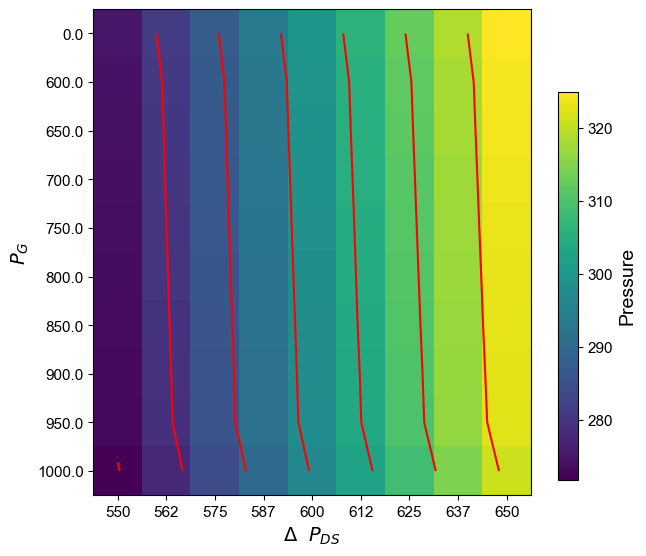

In [116]:

def plot_press2(pt, pt2, file, title, yl='Velocity', legend=True, filename="output.pdf"):
    fig, ax = ret_fig_ax()
    #ax.set_title(title)
    pg = "740.0"    

    radii_list, press_list = [], []
    
    # First pass: collect unique radii and pressure values
    for i in datadir_list:
        #if not re.search(r'' + re.escape(pg) + r'\/data$', i):
        #    continue
        
        #print(i)
        match, match2 = re.search(pt, i), re.search(pt2, i)
        
        if match and match2:
            radius, pressure = float(match.group()), float(match2.group())
            
            radii_list = radii_list + [radius] if radius not in radii_list else radii_list
            press_list = press_list + [pressure] if pressure not in press_list else press_list


    radii, press = np.sort(np.array(radii_list)), np.sort(np.array(press_list))
    # Create the arr with the correct dimensions
    arr = np.empty((len(radii), len(press)))
    print(radii, press, arr.shape)

    
    for i in datadir_list:
        #if not re.search(r'' + re.escape(pg) + r'\/data$', i):
        #    continue

        directory = os.path.dirname(i)
        file_pattern = os.path.basename(file)
        matching_files = find_matching_files(directory, file_pattern)
        
        h_max = get_height_from_dtool(re.sub(r'\/data$', r'', i))
        
        match, match2 = re.search(pt, i), re.search(pt2, i)
        print("match", i) if match is None else None
        print("match2", i) if match2 is None else None      
        extracted, extracted2 = float(match.group()), float(match2.group())
        file_path = matching_files[0]
        u = np.loadtxt(file_path)
        arr[np.where(radii==float(extracted))[0], np.where(press==float(extracted2))[0]] = np.max(u)

    #handles, labels = plt.gca().get_legend_handles_labels()
    #extracted_values = [float(re.search(r'\s*(\d+(?:\.\d+)?)', label).group(1)) for label in labels]

    # Create sorted pairs of (handle, label) based on extracted values
    #sorted_pairs = sorted(zip(handles, labels), key=lambda x: float(re.search(r'\s*(\d+(?:\.\d+)?)', x[1]).group(1)))
    
    #sorted_handles, sorted_labels = zip(*sorted_pairs)
    #plt.legend(sorted_handles, sorted_labels, bbox_to_anchor=(1.0, 1), loc='upper left',frameon=False)
    
    neg = ax.imshow(arr)
    ax.contour(arr, colors='red')
    ax.set_xticks(np.arange(len(press)))
    ax.set_yticks(np.arange(len(radii)))
    ax.set_xticklabels((press).astype(int))
    ax.set_yticklabels(radii)
    plt.tight_layout()
    #plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')
    fig.colorbar(neg, ax=ax, location='right', anchor=(0, 0.3), shrink=0.7, label="Pressure")
    ax.set_ylabel(r'$P_G$', fontsize=14)
    ax.set_xlabel(r'$\Delta$ $~P_{DS}$', fontsize=14)

    plt.show()
    fig.savefig("press_membrane.pdf", format='pdf', dpi=300, bbox_inches='tight')
    return radii, press, arr

radii, press, arr = plot_press2(pat, pat2, "/p_at_5_0.32/p_at_5.txt", r"Velocity at different $P_g$", yl='P delta', legend=True)

In [115]:
arr

array([[275.00745559, 281.25763068, 287.50780603, 293.75798164,
        300.00815751, 306.25833364, 312.50851002, 318.75868667,
        325.00886358],
       [274.27457338, 280.52544342, 286.77057866, 293.0145862 ,
        299.24672114, 305.49134514, 311.7408207 , 317.98152347,
        324.2371575 ],
       [274.09209664, 280.33638777, 286.56420548, 292.81023971,
        299.04873248, 305.27855965, 311.52227398, 317.75218803,
        324.00152744],
       [273.91926909, 280.16656277, 286.37525875, 292.5979064 ,
        298.82247979, 305.047974  , 311.28191187, 317.5084    ,
        323.73693215],
       [273.739041  , 279.93819812, 286.15826333, 292.3873182 ,
        298.60175592, 304.82162954, 311.05555657, 317.26781172,
        323.51232059],
       [273.56562746, 279.77650917, 285.98380174, 292.19271003,
        298.38363635, 304.60783344, 310.82226368, 317.03509235,
        323.23546806],
       [273.36634044, 279.56428396, 285.7633916 , 291.95745893,
        298.16169255, 304.3971